In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Problem 1

In [2]:
# variables - from table 6.2, except latitude
# g_obs = 980658.67 # mGal 
g_n = 978.03185 # Gal 

latitude = np.linspace(-90, 90, 10)
lat_list = [0, 45.62, 89.5] # degrees
elevation = 100.24 # meters.
bouger_density = 2.67 # g_cm-3.
FA_corr = 30.93
B_corr = 11.22
FA_anom = 15.22
B_anom = 4.00

delta_gb = []

In [3]:
# GRS67 Equation 6.28
# final units in mGal
for i in latitude:
    #delta_g = (g_n * (1 + 0.005278895 * math.sin(math.radians(i))**2 + 0.000023462 * math.sin(math.radians(i))**4)) + ((0.3086 - (0.04193 * bouger_density)) * elevation)
    g_obs = g_n * (1 + 0.005278895 * math.sin(math.radians(i))**2 + 0.000023462 * math.sin(math.radians(i))**4)
    delta_gb.append(g_obs)

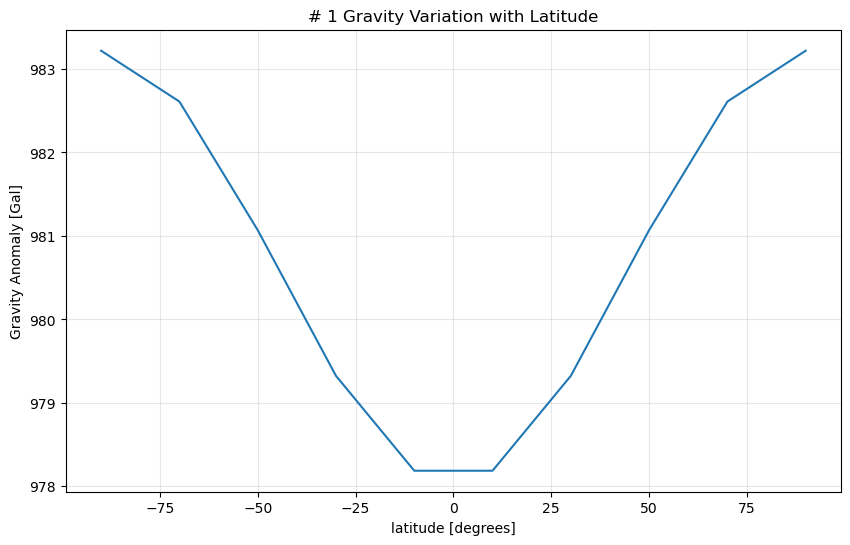

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(latitude, delta_gb)
ax.set_xlabel('latitude [degrees]')
ax.set_ylabel('Gravity Anomaly [Gal]')
ax.set_title('# 1 Gravity Variation with Latitude')
ax.grid(True, alpha=0.3)
plt.show()


Figure 1. Gravitational variation between -90 and 90 degrees latitude using the GRS67 formula. The sin term in the formula evaluates to 0 at the equator and begins to increase around +/- 10 degrees. Gravity varies with latitude because the earth is an ellipsoid where the equator is further away from mass center. The poles are closer to mass center so gravity is stronger.

## Problem 2

In [13]:
z = 152.7 # meters
density = 2500 # kg / m3
free_air_correction = -0.3086 * z

Bouguer_correction = -0.04193 * density * z

print(f'free air = {free_air_correction:.3f} mGal\nBouguer = {Bouguer_correction:.3f} mGal')


free air = -47.123 mGal
Bouguer = -16006.778 mGal


The free air correction is negative because gravity decreases with elevation. The Bourguer correction is negative to account for the effect of mass between the observation point and the geoid.

## Problem 3

In [16]:
csv_path = 'gravity_data.csv'
data_df = pd.read_csv(csv_path)

In [17]:
# Convert Time column to datetime, then calculate elapsed time in minutes
data_df['Time'] = pd.to_datetime(data_df['Time'], format='%H:%M')
first_time = data_df['Time'].iloc[0]
data_df['time_elapsed'] = (data_df['Time'] - first_time).dt.total_seconds() / 60

In [18]:
# Separate Base and non-Base data
base_mask = data_df['Station'] == 'Base'
non_base = data_df[~base_mask]
base = data_df[base_mask]

In [ ]:
dial_constant = 0.0869
drift_rate = (base['Readings'].iloc[0] - base['Readings'].iloc[-1]) / base['time_elapsed'].iloc[-1]
corrected_g = non_base['Readings'] - (non_base['time_elapsed'] * drift_rate * dial_constant)
# OR THIS?
#corrected_g = (non_base['Readings'] * dial_constant) - (non_base['time_elapsed'] * drift_rate * dial_constant)
# an array of zeros to plot all corrected values at 11:20
corrected_times = np.zeros(4)

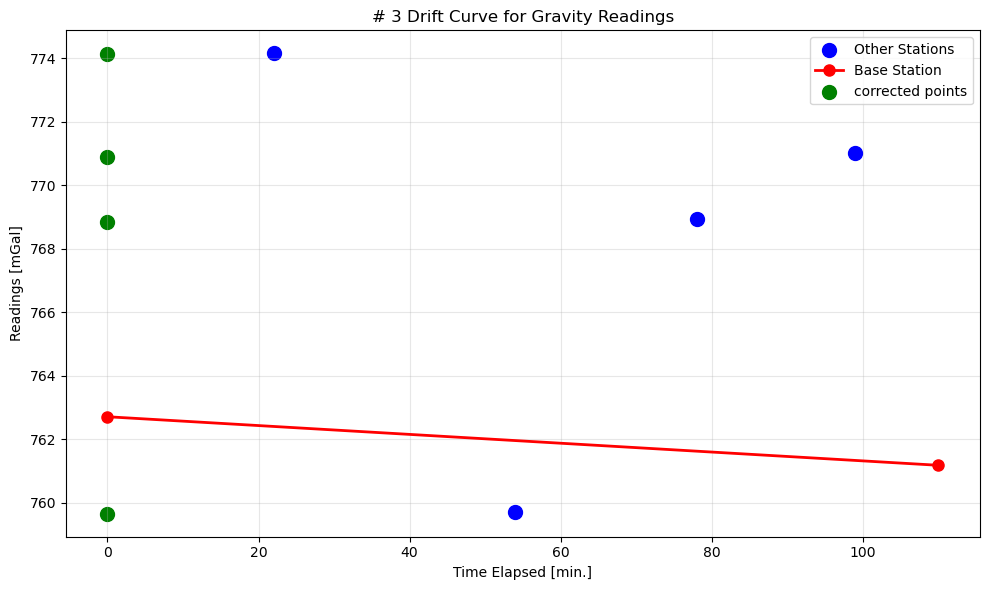

In [22]:
# Create scatter plot with different colors for Base station
fig, ax = plt.subplots(figsize=(10, 6))

# Plot non-Base stations as blue marker with line
ax.scatter(non_base['time_elapsed'], non_base['Readings'], 
           color='blue', marker='o', label='Other Stations', s=100)

# Plot Base stations as red markers
ax.plot(base['time_elapsed'], base['Readings'], 
        color='red', marker='o', label='Base Station', linewidth=2, markersize=8)

# Plot corrected non-Base stations as green markers
ax.scatter(corrected_times, corrected_g, 
           color='green', marker='o', label='corrected points', s=100)

ax.set_xlabel('Time Elapsed [min.]')
ax.set_ylabel('Readings [mGal]')
ax.set_title('# 3 Drift Curve for Gravity Readings')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [36]:
# display the corrected g values
for station, g in zip(non_base['Station'],corrected_g):
    print(f'corrected value at {station} = {g:.3f} mGal')

corrected value at GN1 = 774.133 mGal
corrected value at GN2 = 759.655 mGal
corrected value at GN3 = 768.856 mGal
corrected value at GN4 = 770.900 mGal


## Problem 4 submitted as photo

## Problem 5

In [30]:
bouguer_path = 'bouguer_anomoly_data.csv'
bouguer_df = pd.read_csv(bouguer_path)

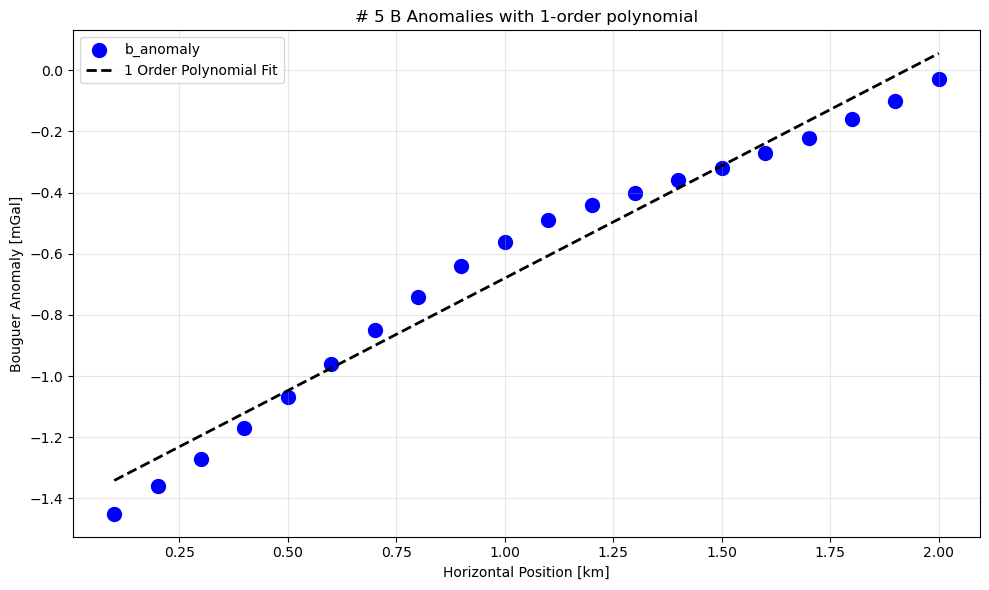

In [31]:
# Create scatter plot with different colors for Base station
fig, ax = plt.subplots(figsize=(10, 6))


# Plot non-Base stations
ax.scatter(bouguer_df['horizontal_position_km'], bouguer_df['Bouguer_Anomaly_mGal'], 
           color='blue', marker='o', label='b_anomaly', s=100)

# Fit an n-order polynomial to the data
n = 1
coefficients = np.polyfit(bouguer_df['horizontal_position_km'], bouguer_df['Bouguer_Anomaly_mGal'], n)
polynomial = np.poly1d(coefficients)

# Create smooth x-values for plotting the trend line
x_smooth = np.linspace(bouguer_df['horizontal_position_km'].min(), bouguer_df['horizontal_position_km'].max(), 100)
y_smooth = polynomial(x_smooth)


# Add the polynomial trend line to the plot
ax.plot(x_smooth, y_smooth, 'k--', linewidth=2, label=f'{n} Order Polynomial Fit')
if n ==3:
        equation_str = f'y = {coefficients[0]:.4f}x³ + {coefficients[1]:.4f}x² + {coefficients[2]:.4f}x + {coefficients[3]:.4f}'
        ax.text(0.05, 0.95, equation_str, transform=ax.transAxes, 
                fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax.set_xlabel('Horizontal Position [km]')
ax.set_ylabel('Bouguer Anomaly [mGal]')
ax.set_title(f'# 5 B Anomalies with {n}-order polynomial')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [32]:
# calculate the anomalies using the n-order polynomial for each transect
b_fit = polynomial(bouguer_df['horizontal_position_km'])
# subract the original anomalies from the estimated values
b_corrected = bouguer_df['Bouguer_Anomaly_mGal'] - b_fit

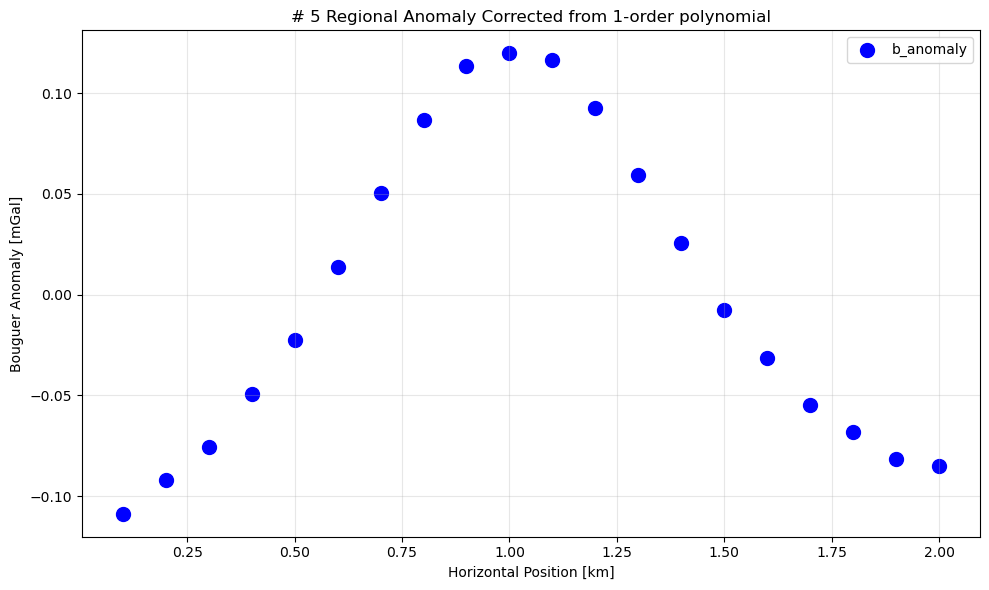

In [33]:
# Plot corrected positions
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(bouguer_df['horizontal_position_km'], b_corrected, 
           color='blue', marker='o', label='b_anomaly', s=100)

ax.set_xlabel('Horizontal Position [km]')
ax.set_ylabel('Bouguer Anomaly [mGal]')
ax.set_title(f'# 5 Regional Anomaly Corrected from {n}-order polynomial')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [34]:
half_max = b_corrected.max() / 2
print(f'Bouguer anomaly at the half max = {half_max:.3f} mGal')  

Bouguer anomaly at the half max = 0.060 mGal


## Problem 6 submitted as photo